<a href="https://colab.research.google.com/github/Mahmood-Anaam/Artificial-Intelligence/blob/main/Backbone_EfficientNetV2_B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
!pip install keras-cv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 26.9 MB/s eta 0:00:00


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt

## Configuration

In [ ]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    neg_sample = 0.01 # Downsample negative calss
    pos_sample = 5.0  # Upsample positive class
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [128, 128]  # Input image size
    epochs = 2 # Training epochs
    batch_size = 256  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    class_names = ['target']
    num_classes = 1


**Sets value for random seed to produce similar result in each run.**

In [ ]:
keras.utils.set_random_seed(CFG.seed)

## Dataset

In [ ]:
import kagglehub

# Username : engmahmoodanaam
# Token    : a12f4f02a033ce24866d584d7f49df49

kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
isic_2024_challenge_path = kagglehub.competition_download('isic-2024-challenge')
print('Data source import complete.')
print(f'Data source path: {isic_2024_challenge_path}')

100%|██████████| 2.00G/2.00G [00:30<00:00, 69.4MB/s]

Extracting files...


Data source import complete.
Data source path: /root/.cache/kagglehub/competitions/isic-2024-challenge


In [ ]:
BASE_PATH = isic_2024_challenge_path

## Meta Data

In this dataset, following information is available:

- **train-image/**: Contains image files for the training set (provided for train only).
- **train-image.hdf5**: Training image data stored in a single HDF5 file, where each image is indexed by its `isic_id`.
- **train-metadata.csv**: Metadata corresponding to the training set, including:
  - `isic_id`: Unique image ID used to query images in the HDF5 file.
  - `patient_id`: Unique patient ID.
  - `sex`: Gender of the patient.
  - `age_approx`: Approximate age of the patient.
  - `anatom_site_general`: Location of the lesion.
  - Other relevant metadata fields.
- **test-image.hdf5**: Testing image data stored in a single HDF5 file, initially containing 3 testing examples to validate the inference pipeline. Upon notebook submission, this file is replaced with the full hidden testing set, which contains approximately 500,000 images.
- **test-metadata.csv**: Metadata corresponding to the testing subset.


In [ ]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')
df = df.ffill()
display(df.head(2))

# Testing
testing_df = pd.read_csv(f'{BASE_PATH}/test-metadata.csv')
testing_df = testing_df.ffill()
display(testing_df.head(2))

<ipython-input-14-62ed73d212c3>:2: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{BASE_PATH}/train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY


## Handle Class Imbalance

### Sample Data

There is a significant class imbalance in the dataset, with a large number of negative samples compared to positive samples. To address this issue, the negative class will be downsampled and upsample the positive class. To experiment with full dataset, simply adjust the `pos_sample` and `neg_sample` settings in `CFG`.

In [ ]:
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Sampling
positive_df = df.query("target==0").sample(frac=CFG.neg_sample, random_state=CFG.seed)
negative_df = df.query("target==1").sample(frac=CFG.pos_sample, replace=True, random_state=CFG.seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nCalss Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

Class Distribution Before Sampling (%):


,proportion
target,
0,99.902009
1,0.097991



Calss Distribution After Sampling (%):


,proportion
target,
0,67.09645
1,32.90355


### Class Weight

Even after downsampling the negative class and upsampling the positive class, there remains a significant class imbalance. To further address this imbalance during training, loss weighting will be used. This technique ensures that the model weights are updated more heavily for the positive samples, thereby reducing the bias towards the negative class. The following code computes the class weights for the loss:

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.7451959071624656, 1: 1.519592875318066}


## Load Image




In [ ]:
import h5py

training_validation_hdf5 = h5py.File(f"{BASE_PATH}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{BASE_PATH}/test-image.hdf5", 'r')

##  Examining a sample image

Examining a sample image from the provided data is important. This step allows for a closer inspection of the image quality and content, ensuring it meets the requirements for further processing.

Byte String: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'....
Image:


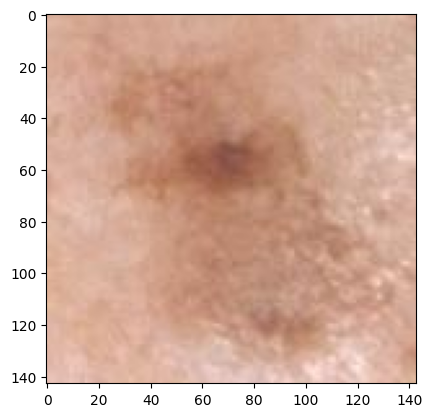

In [ ]:
isic_id = df.isic_id.iloc[0]

# Image as Byte String
byte_string = training_validation_hdf5[isic_id][()]
print(f"Byte String: {byte_string[:20]}....")

# Convert byte string to numpy array
nparr = np.frombuffer(byte_string, np.uint8)

print("Image:")
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
plt.imshow(image);

## Data Split

In the following code,the data will be splitted into `5` stratified folds and use the first fold for training and validation. It's important to note that `StratifiedGroupKFold` is being used to ensure that `patient_id`s do not overlap between the training and validation datasets. This prevents data leakage, where the model could potentially peak at data it should not have access to.




In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

df = df.reset_index(drop=True) # ensure continuous index
df["fold"] = -1
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)
for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.patient_id)):
    df.loc[validation_idx, "fold"] = int(i)

# Use first fold for training and validation
training_df = df.query("fold!=0")
validation_df = df.query("fold==0")
print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")

# Num Train: 4706 | Num Valid: 1266


## Class Distribution in Training

In [ ]:
training_df.target.value_counts()

,count
target,
0,3088
1,1618


## Class Distribution in Validation

In [ ]:
validation_df.target.value_counts()

,count
target,
0,919
1,347


## DataLoader


In [ ]:
def build_augmenter():
    # Define augmentations
    aug_layers = [
        keras_cv.layers.RandomCutout(height_factor=(0.02, 0.06), width_factor=(0.02, 0.06)),
        keras_cv.layers.RandomFlip(mode="horizontal"),
    ]

    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]

    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        # Read jpeg image
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)

        # Resize
        image = tf.image.resize(image, size=target_size, method="area")

        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0

        # Reshape
        image = tf.reshape(image, [*target_size, 3])

        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, CFG.num_classes)
        return (inp, label)

    return decode_with_labels if with_labels else decode_image


def build_dataset(
    isic_ids,
    hdf5,
    labels=None,
    batch_size=32,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    shuffle=1024,
    cache=True,
    drop_remainder=False,
):
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    images = [None]*len(isic_ids)
    for i, isic_id in enumerate(tqdm(isic_ids, desc="Loading Images ")):
        images[i] = hdf5[isic_id][()]

    inp = {"images": images}
    slices = (inp, labels) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

### Build Training & Validation Dataset

In the following code, **training** and **validation** data loaders will be created.

In [ ]:
## Train
print("# Training:")

training_ids = training_df.isic_id.values
training_labels = training_df.target.values
training_ds = build_dataset(training_ids, training_validation_hdf5,
                         training_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=True)

# Valid
print("# Validation:")

validation_ids = validation_df.isic_id.values
validation_labels = validation_df.target.values
validation_ds = build_dataset(validation_ids, training_validation_hdf5,
                         validation_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)


# Training:


Loading Images :   0%|          | 0/4706 [00:00<?, ?it/s]

# Validation:


Loading Images :   0%|          | 0/1266 [00:00<?, ?it/s]

### Output Shape of a Batch

Verifying the shape of a batch sample is essential. This step ensures that the dataloader is generating inputs with the correct dimensions, which is critical for the model's performance.

In [ ]:
batch = next(iter(validation_ds))

print("Images:",batch[0]["images"].shape)
print("Targets:", batch[1].shape)

Images: (256, 128, 128, 3)
Targets: (256, 1)


### Visualizing samples

Visualizing samples along with their associated labels from the dataset is a vital step. This process helps in understanding the data distribution and ensures that the dataset is correctly labeled.

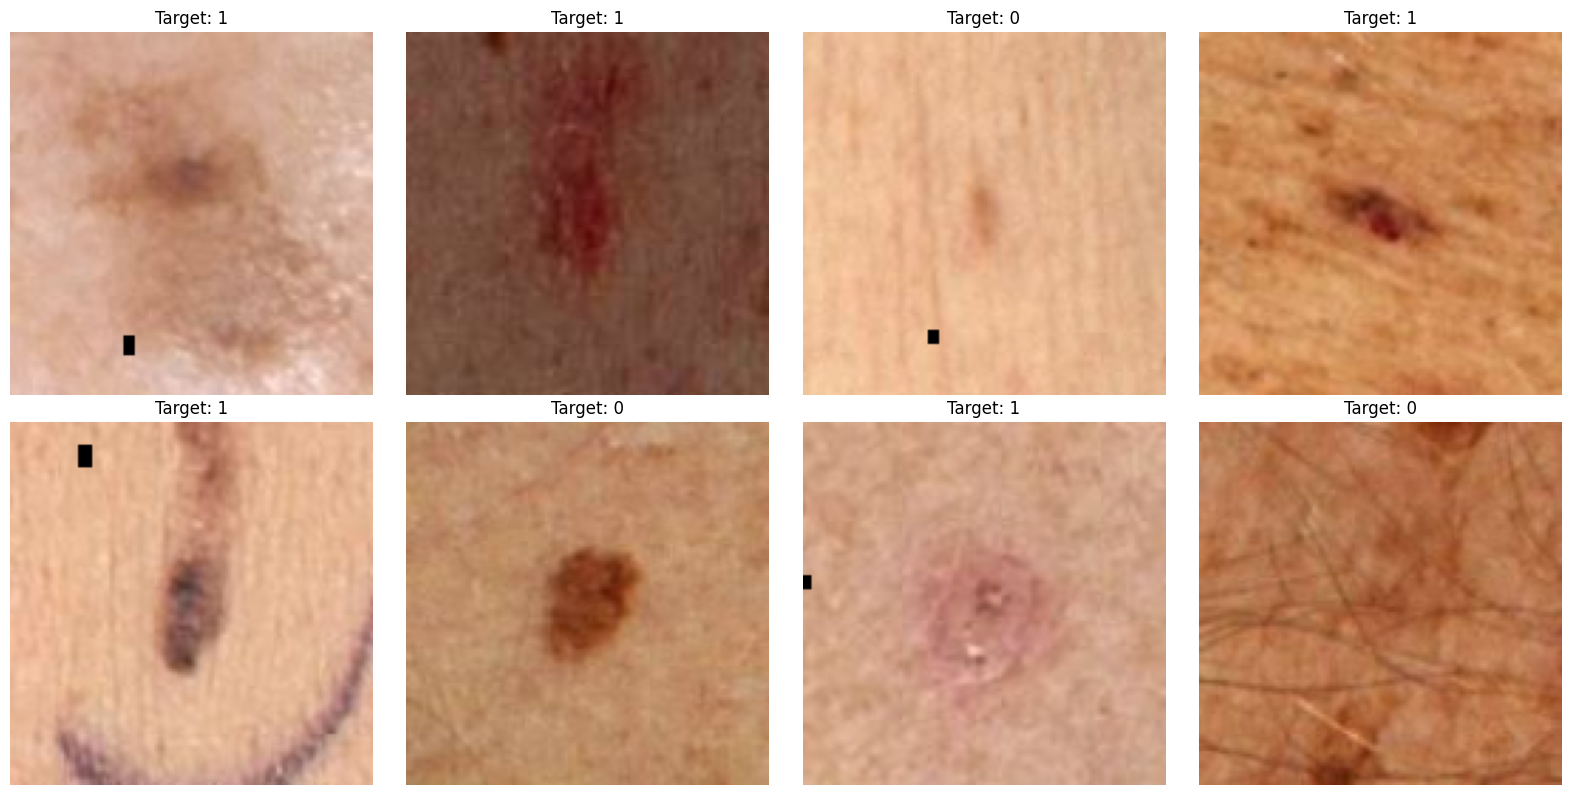

In [ ]:
inputs, targets = next(iter(training_ds))
images = inputs["images"]
num_images, NUMERIC_COLUMNS = 8, 4

plt.figure(figsize=(4 * NUMERIC_COLUMNS, num_images // NUMERIC_COLUMNS * 4))
for i, (image, target) in enumerate(zip(images[:num_images], targets[:num_images])):
    plt.subplot(num_images // NUMERIC_COLUMNS, NUMERIC_COLUMNS, i + 1)
    image = image.numpy().astype("float32")
    target= target.numpy().astype("int32")[0]

    image = (image - image.min()) / (image.max() + 1e-4)

    plt.imshow(image)
    plt.title(f"Target: {target}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Loss & Metric

We will use the partial area under the curve (pAUC) metric for evaluation. In Keras, there is a similar metric called ROC AUC, which can be used for approximate evaluation. To optimize our model, we will use the binary cross entropy (BCE) loss from Keras.

It's important to note that BCE loss is sensitive to class imbalance. To mitigate this issue, the class weights will be used which is computed earlier. These weights will prioritize updating the model weights more strongly for the minority class (positive class), thereby mitigating class imbalance.


In [ ]:
# AUC
auc = keras.metrics.AUC()

# Loss
loss = keras.losses.BinaryCrossentropy(label_smoothing=0.02)

## Modeling







### LR Schedule

A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 2.5e-5, 5e-6 * batch_size, 0.8e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

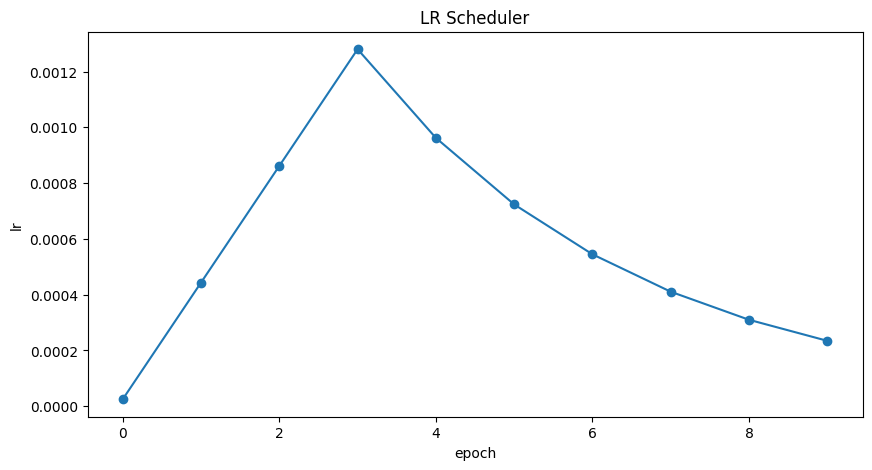

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, mode="exp", plot=True)

### Model Checkpoint

The `ModelCheckpoint` callback is used to save the model during training. It monitors the performance of the model on the validation data and saves the model with the best performance based on a specified metric.

Following setup ensures that the model with the highest validation AUC (`val_auc`) during training is saved to the file `best_model.keras`. Only the best model is saved, preventing overwriting with worse-performing models.

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",   # Filepath where the model will be saved.
    monitor="val_auc",    # Metric to monitor (validation AUC in this case).
    save_best_only=True,  # Save only the model with the best performance.
    save_weights_only=False,  # Save the entire model (not just the weights).
    mode="max",           # The model with the maximum 'val_auc' will be saved.
)



---



### Backbone EfficientNetV2 B2

In this model, we use the `EfficientNetV2 B2` backbone of pre-trained KerasCV models to extract features from images. The last layer (the head) is a `Dense` layer with a `sigmoid` activation function. The `sigmoid` activation is chosen because the objective is binary; `softmax` would have been chosen if the objective was multi-class.

In [ ]:
# Define input layers
image_input = keras.Input(shape=(*CFG.image_size, 3), name="images")


# Branch for image input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)
x1 = backbone(image_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)

# Output layer
out = keras.layers.Dense(1, activation="sigmoid", dtype="float32")(x1)

# Build model
model = keras.models.Model(image_input, out)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss,
    metrics=[auc],
)

# Model Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b2_backbone          │ (None, 4, 4, 1408)          │       8,769,374 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,409 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,770,783 (33.46 MB)

 Trainable params: 8,688,495 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

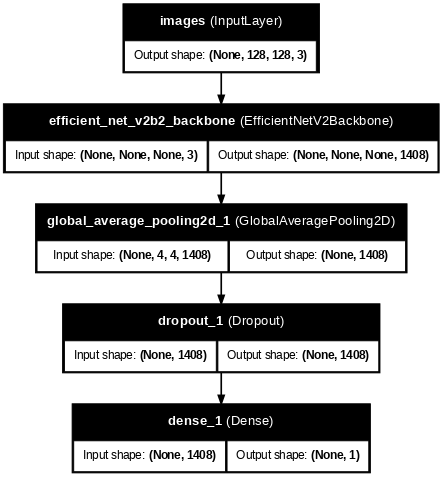

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=60)


### Training

Follwing cell will train the prepared model. Notice that, `class_weight` is used in the training.

In [ ]:
history = model.fit(
    training_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    validation_data=validation_ds,
    verbose=CFG.verbose,
    class_weight=class_weights,
)

Epoch 1/2
19/19 ━━━━━━━━━━━━━━━━━━━━ 846s 39s/step - auc: 0.5441 - loss: 0.7008 - val_auc: 0.4418 - val_loss: 0.6155 - learning_rate: 2.5000e-05
Epoch 2/2
19/19 ━━━━━━━━━━━━━━━━━━━━ 682s 34s/step - auc: 0.8036 - loss: 0.5745 - val_auc: 0.4455 - val_loss: 0.6045 - learning_rate: 4.4333e-04


### Visualize AUC with Epochs

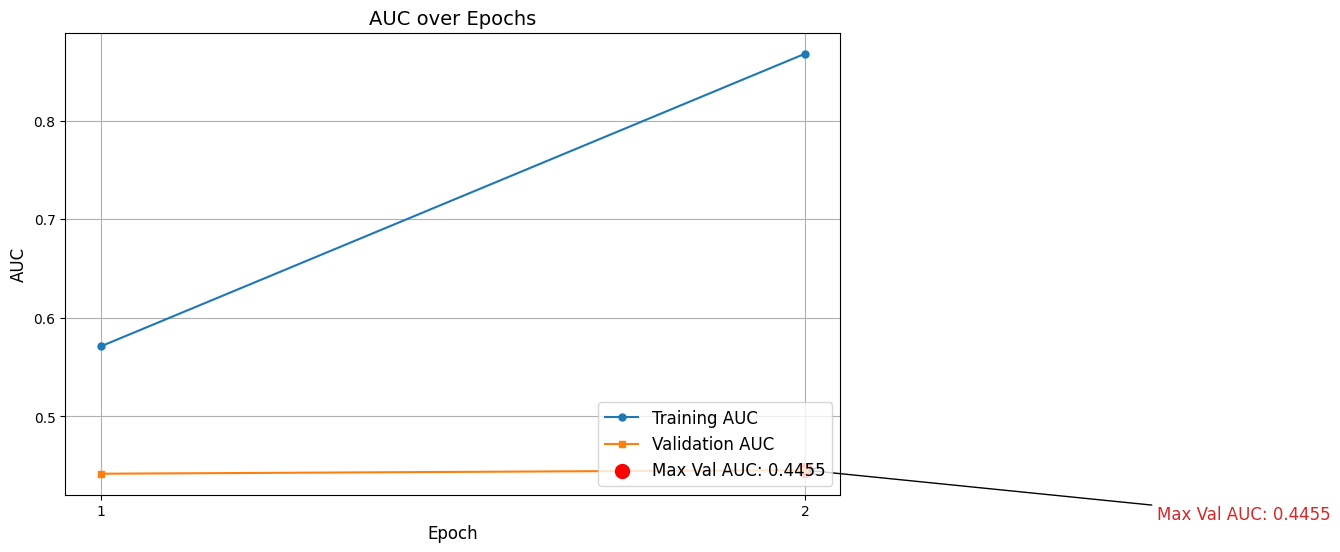

In [ ]:
# Extract AUC and validation AUC from history
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)

# Find the epoch with the maximum val_auc
max_val_auc_epoch = np.argmax(val_auc)
max_val_auc = val_auc[max_val_auc_epoch]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, auc, 'o-', label='Training AUC', markersize=5, color='tab:blue')
plt.plot(epochs, val_auc, 's-', label='Validation AUC', markersize=5, color='tab:orange')

# Highlight the max val_auc
plt.scatter(max_val_auc_epoch + 1, max_val_auc, color='red', s=100, label=f'Max Val AUC: {max_val_auc:.4f}')
plt.annotate(f'Max Val AUC: {max_val_auc:.4f}',
             xy=(max_val_auc_epoch + 1, max_val_auc),
             xytext=(max_val_auc_epoch + 1 + 0.5, max_val_auc - 0.05),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             color='tab:red')

# Enhancing the plot
plt.title('AUC over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.xticks(epochs)

# Show the plot
plt.show()

### Result

In [ ]:
# Best Result
best_score = max(history.history['val_auc'])
best_epoch = np.argmax(history.history['val_auc']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best AUC: {best_score:.5f}")
print(f"Best Epoch: {best_epoch}")
print("#" * 28)

########## Result ##########
Best AUC: 0.44549
Best Epoch: 2
############################


---
## Prediction

### Load Best Model

In [ ]:
model.load_weights("best_model.keras")

### Build Testing Dataset

Don't forget to normalize for the testing data as well.

In [ ]:
# Testing
print("# Testing:")
testing_ids = testing_df.isic_id.values
testing_ds = build_dataset(testing_ids, testing_hdf5,
                         batch_size=CFG.batch_size,
                         shuffle=False, augment=False, cache=False)


# Testing:


Loading Images :   0%|          | 0/3 [00:00<?, ?it/s]

### Inference

In [ ]:
preds = model.predict(testing_ds).squeeze()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


### Check Prediction

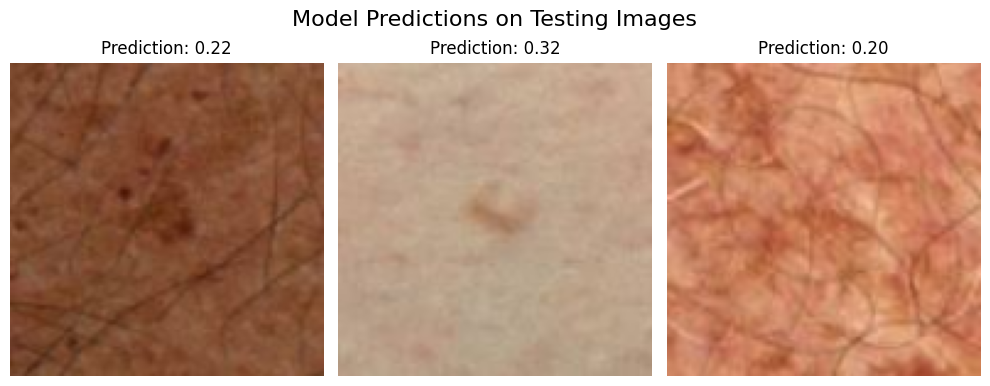

In [ ]:
inputs = next(iter(testing_ds))
images = inputs["images"]

# Plotting
plt.figure(figsize=(10, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, i+1th subplot
    plt.imshow(images[i])  # Show image
    plt.title(f'Prediction: {preds[i]:.2f}')  # Set title with prediction
    plt.axis('off')  # Hide axis

plt.suptitle('Model Predictions on Testing Images', fontsize=16)
plt.tight_layout()
plt.show()